# Billionaires

In [1]:
import pandas as pd
import zipfile
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Define the path to the ZIP file
zip_file_path = 'Billionaires Statistics Dataset.zip'

# Extract and load the CSV file from the ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_name_in_zip = 'Billionaires Statistics Dataset.csv'  # Ensure this matches the file name in the ZIP
    with zip_ref.open(file_name_in_zip) as file:
        data = pd.read_csv(file)

# Data Inspection and Cleaning
display(data.head())
data.info()
data.describe()
data.isnull().sum()

rank  finalWorth               category                personName   age  \
0     1      211000       Fashion & Retail  Bernard Arnault & family  74.0   
1     2      180000             Automotive                 Elon Musk  51.0   
2     3      114000             Technology                Jeff Bezos  59.0   
3     4      107000             Technology             Larry Ellison  78.0   
4     5      106000  Finance & Investments            Warren Buffett  92.0   

         country    city              source             industries  \
0         France   Paris                LVMH       Fashion & Retail   
1  United States  Austin       Tesla, SpaceX             Automotive   
2  United States  Medina              Amazon             Technology   
3  United States   Lanai              Oracle             Technology   
4  United States   Omaha  Berkshire Hathaway  Finance & Investments   

  countryOfCitizenship  ... cpi_change_country           gdp_country  \
0               France  ...                1.1   $2,715,518,274,227    
1        United States  ...                7.5  $21,427,700,000,000    
2        United States  ...                7.5  $21,427,700,000,000    
3        United States  ...                7.5  $21,427,700,000,000    
4        United States  ...                7.5  $21,427,700,000,000    

  gross_tertiary_education_enrollment  \
0                                65.6   
1                                88.2   
2                                88.2   
3                                88.2   
4                                88.2   

  gross_primary_education_enrollment_country life_expectancy_country  \
0                                      102.5                    82.5   
1                                      101.8                    78.5   
2                                      101.8                    78.5   
3                                      101.8                    78.5   
4                                      101.8                    78.5   

  tax_revenue_country_country total_tax_rate_country population_country  \
0                        24.2                   60.7         67059887.0   
1                         9.6                   36.6        328239523.0   
2                         9.6                   36.6        328239523.0   
3                         9.6                   36.6        328239523.0   
4                         9.6                   36.6        328239523.0   

  latitude_country longitude_country  
0        46.227638          2.213749  
1        37.090240        -95.712891  
2        37.090240        -95.712891  
3        37.090240        -95.712891  
4        37.090240        -95.712891  

[5 rows x 35 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

rank                                             0
finalWorth                                       0
category                                         0
personName                                       0
age                                             65
country                                         38
city                                            72
source                                           0
industries                                       0
countryOfCitizenship                             0
organization                                  2315
selfMade                                         0
status                                           0
gender                                           0
birthDate                                       76
lastName                                         0
firstName                                        3
title                                         2301
date                                             0
state                          

In [ ]:
# Data Cleaning and Preprocessing

In [14]:
# Drop unnecessary columns
columns_to_drop = ['organization', 'title', 'state', 'residenceStateRegion', 'birthMonth', 'birthDay']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 🔹 Fill missing values
data['age'].fillna(data['age'].mean(), inplace=True)  # Replace missing age values with mean
data['country'].fillna('Unknown', inplace=True)
data['city'].fillna('Unknown', inplace=True)

# 🔹 Clean non-numeric symbols in financial columns
data['finalWorth'] = pd.to_numeric(data['finalWorth'].replace(r'[\$,]', '', regex=True), errors='coerce')
data['gdp_country'] = pd.to_numeric(data['gdp_country'].replace(r'[\$,]', '', regex=True), errors='coerce')

# 🔹 List of country-related columns for median imputation
country_columns = [
    'cpi_country', 'gross_tertiary_education_enrollment', 'gross_primary_education_enrollment_country',
    'life_expectancy_country', 'population_country', 'cpi_change_country', 
    'tax_revenue_country_country', 'total_tax_rate_country'
]

# Impute missing values using the median for country-related columns
for col in country_columns:
    data[col].fillna(data[col].median(), inplace=True)

# 🔹 Convert date columns to datetime format
date_columns = ['date', 'birthDate']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# 🔹 Fill missing birthDate using birthYear
def infer_birthdate(row):
    """Infers birthDate from birthYear, birthMonth, and birthDay if missing."""
    if pd.isnull(row['birthDate']) and not pd.isnull(row['birthYear']):
        try:
            return pd.to_datetime(f"{int(row['birthYear'])}-01-01", errors='coerce')  # Default to Jan 1 if month/day missing
        except:
            return np.nan
    return row['birthDate']

data['birthDate'] = data.apply(infer_birthdate, axis=1)

# 🔹 Fill missing gdp_country, latitude_country, longitude_country using median values per country
for col in ['gdp_country', 'latitude_country', 'longitude_country']:
    data[col] = data.groupby('country')[col].transform(lambda x: x.fillna(x.median()))

# 🔹 Convert selfMade column from Boolean to integer (0 = Not Self-Made, 1 = Self-Made)
data['selfMade'] = data['selfMade'].astype(int)

# Display final dataset info
print("✅ Missing values handled successfully!")
print(data.info())

✅ Missing values handled successfully!
<class 'pandas.core.frame.DataFrame'>
Index: 2564 entries, 0 to 2639
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   rank                                        2564 non-null   int64         
 1   finalWorth                                  2564 non-null   int64         
 2   category                                    2564 non-null   object        
 3   personName                                  2564 non-null   object        
 4   age                                         2564 non-null   float64       
 5   country                                     2564 non-null   object        
 6   city                                        2564 non-null   object        
 7   source                                      2564 non-null   object        
 8   industries                                  2564 non-n

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3448439130.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].mean(), inplace=True)  # Replace missing age values with mean
C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3448439130.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [5]:
# Import pandas for data manipulation
import pandas as pd

# Load the saved cleaned data
# data_cleaned = pd.read_csv('cleaned_billionaires_data.csv')

# Inspect the first few rows of the dataset
print("First few rows of the cleaned data:")
print(data_cleaned.head())

# Display summary information about the dataset
print("\nSummary of the dataset:")
print(data_cleaned.info())

# Show basic statistics for numerical columns
print("\nBasic statistics of numerical features:")
print(data_cleaned.describe())

# Display the columns of the dataset to check their names
print("\nColumns in the dataset:")
print(data_cleaned.columns)


First few rows of the cleaned data:
   rank  finalWorth               category                personName   age  \
0     1      211000       Fashion & Retail  Bernard Arnault & family  74.0   
1     2      180000             Automotive                 Elon Musk  51.0   
2     3      114000             Technology                Jeff Bezos  59.0   
3     4      107000             Technology             Larry Ellison  78.0   
4     5      106000  Finance & Investments            Warren Buffett  92.0   

         country    city              source             industries  \
0         France   Paris                LVMH       Fashion & Retail   
1  United States  Austin       Tesla, SpaceX             Automotive   
2  United States  Medina              Amazon             Technology   
3  United States   Lanai              Oracle             Technology   
4  United States   Omaha  Berkshire Hathaway  Finance & Investments   

  countryOfCitizenship  ...  cpi_change_country   gdp_country  \
0  

Columns in the dataset: Index(['rank', 'finalWorth', 'category', 'personName', 'age', 'country',
       'city', 'source', 'industries', 'countryOfCitizenship', 'selfMade',
       'status', 'gender', 'birthDate', 'lastName', 'firstName', 'date',
       'birthYear', 'cpi_country', 'cpi_change_country', 'gdp_country',
       'gross_tertiary_education_enrollment',
       'gross_primary_education_enrollment_country', 'life_expectancy_country',
       'tax_revenue_country_country', 'total_tax_rate_country',
       'population_country', 'latitude_country', 'longitude_country',
       'Wealth Category'],
      dtype='object')


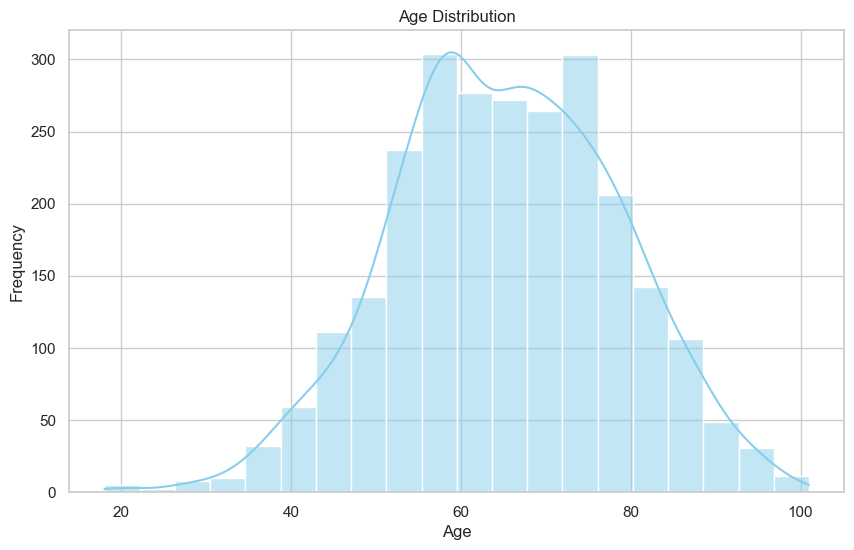

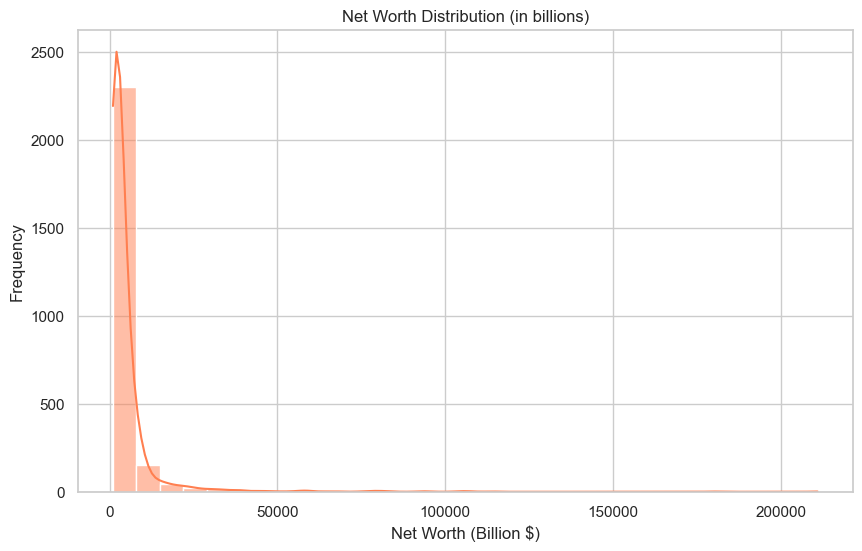

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1203505343.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




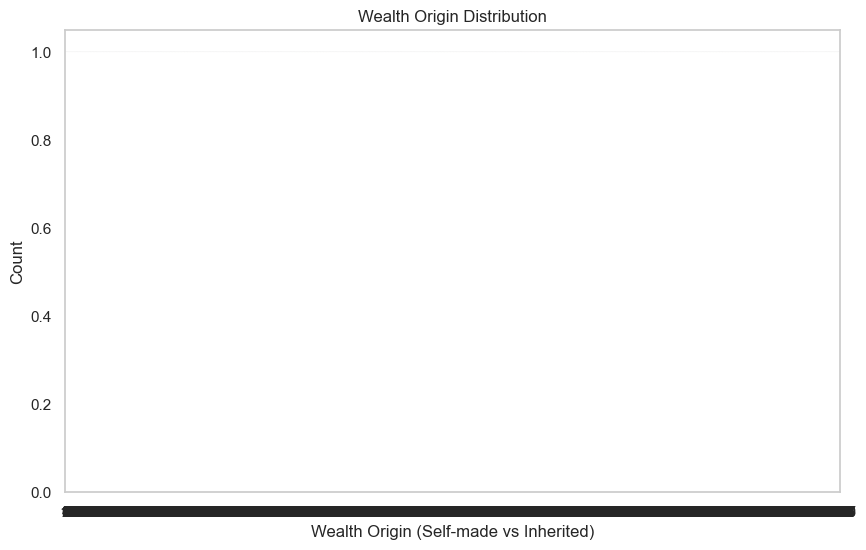

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1203505343.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




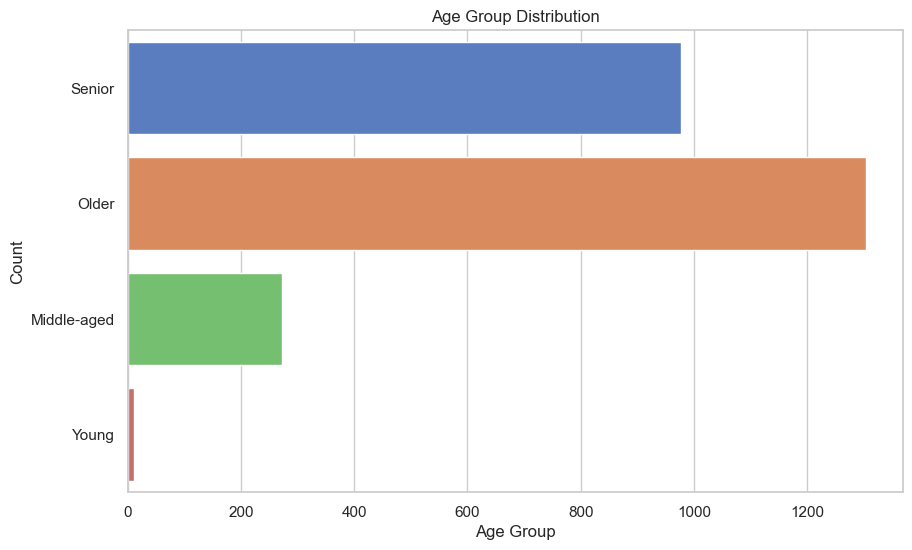

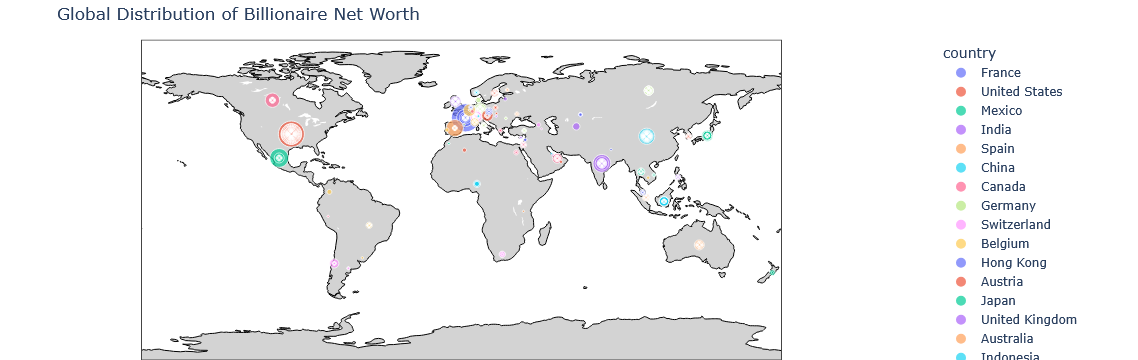

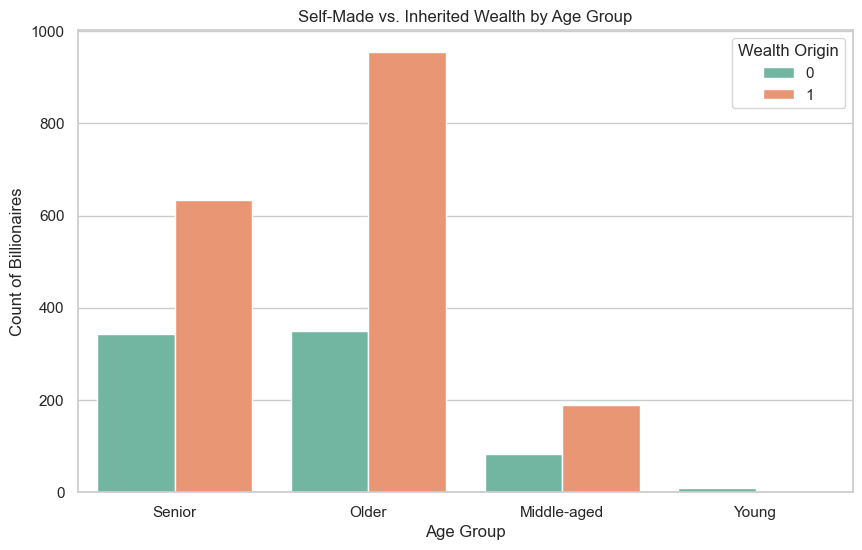

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1203505343.py:87: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




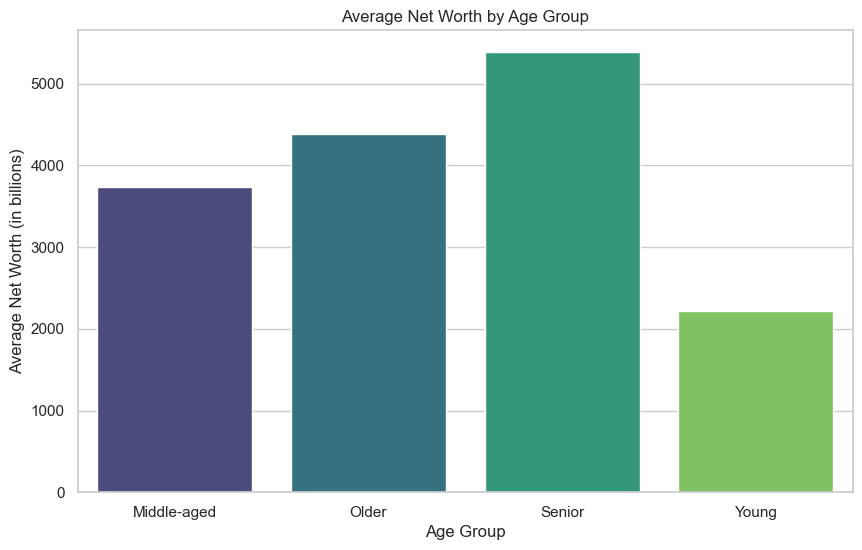

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1203505343.py:95: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




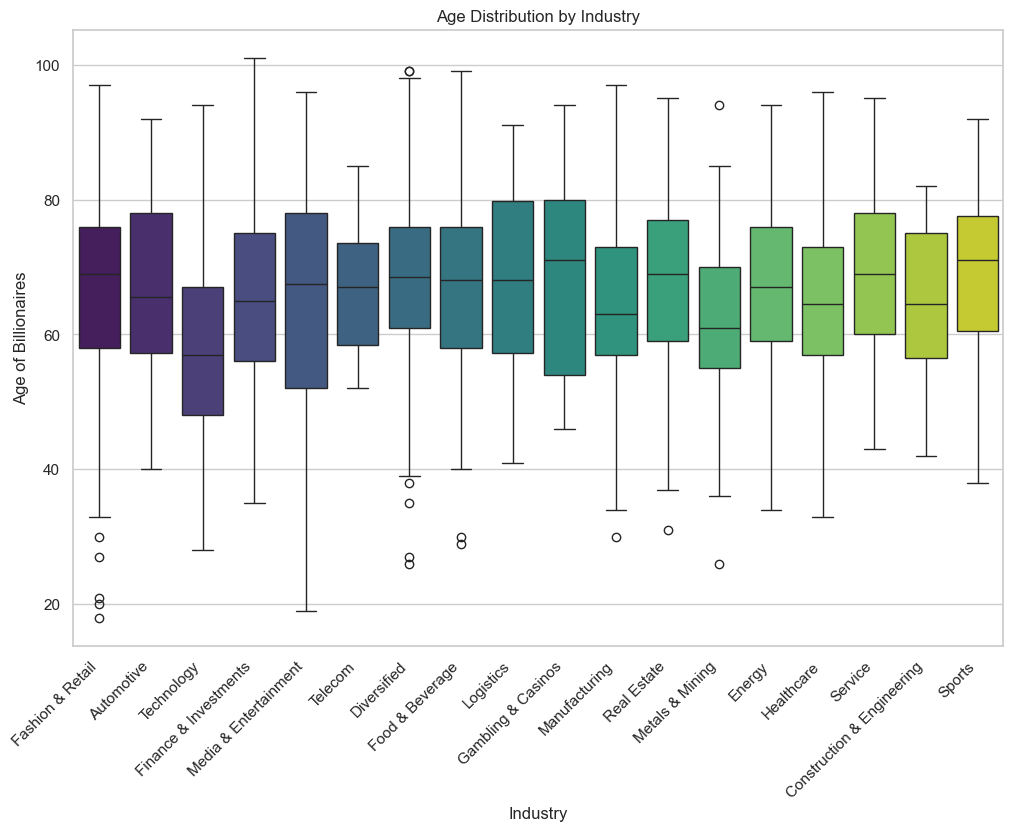

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1203505343.py:105: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




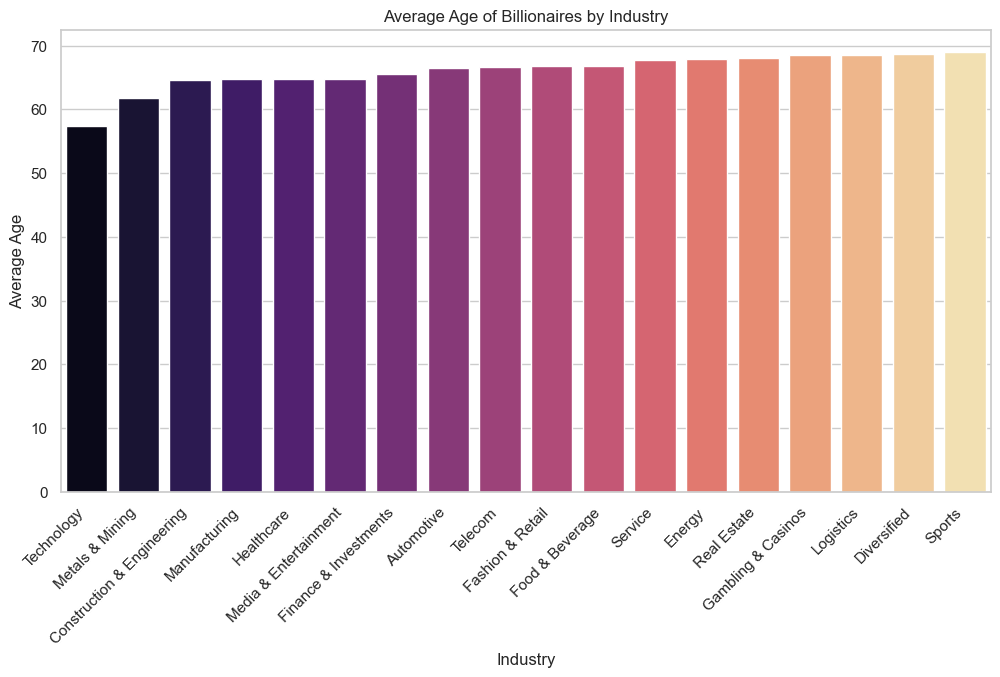

In [40]:
# Check the columns of the dataset to identify the correct column name

# Create Age Group Column
def age_group(age):
    if age < 30:
        return "Young"
    elif 30 <= age < 50:
        return "Middle-aged"
    elif 50 <= age < 70:
        return "Older"
    else:
        return "Senior"

data['age_group'] = data['age'].apply(age_group)

# Exploratory Data Analysis

# Set visualization aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Distribution of Numerical Features
# Age Distribution
plt.figure()
sns.histplot(data['age'], kde=True, color="skyblue", bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Net Worth Distribution (in billions)
plt.figure()
sns.histplot(data['finalWorth'], kde=True, color="coral", bins=30)
plt.title('Net Worth Distribution (in billions)')
plt.xlabel('Net Worth (Billion $)')
plt.ylabel('Frequency')
plt.show()

# Categorical Distributions

# Age Group Distribution
plt.figure()
sns.countplot(data['age_group'], palette="muted")
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Geographical Analysis - Billionaire Net Worth by Country
fig = px.scatter_geo(data, 
                     lat='latitude_country', 
                     lon='longitude_country',
                     color='country',
                     size='finalWorth',  # Assuming 'finalWorth' represents net worth
                     hover_name='country',
                     hover_data={'finalWorth': True},
                     title="Global Distribution of Billionaire Net Worth")
fig.update_geos(showland=True, landcolor="lightgrey", coastlinecolor="black")
fig.update_layout(height=600, margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

# Analysis by Age and Wealth Origin
if 'selfMade' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='age_group', hue='selfMade', palette='Set2')
    plt.title("Self-Made vs. Inherited Wealth by Age Group")
    plt.xlabel("Age Group")
    plt.ylabel("Count of Billionaires")
    plt.legend(title="Wealth Origin")
    plt.show()

# Average Net Worth by Age Group
average_net_worth_by_age_group = data.groupby('age_group')['finalWorth'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=average_net_worth_by_age_group, x='age_group', y='finalWorth', palette='viridis')
plt.title("Average Net Worth by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Net Worth (in billions)")
plt.show()

# Relationship between Age and Industry
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='industries', y='age', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Age Distribution by Industry")
plt.xlabel("Industry")
plt.ylabel("Age of Billionaires")
plt.show()

# Average Age by Industry
average_age_by_industry = data.groupby('industries')['age'].mean().sort_values().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=average_age_by_industry, x='industries', y='age', palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title("Average Age of Billionaires by Industry")
plt.xlabel("Industry")
plt.ylabel("Average Age")
plt.show()


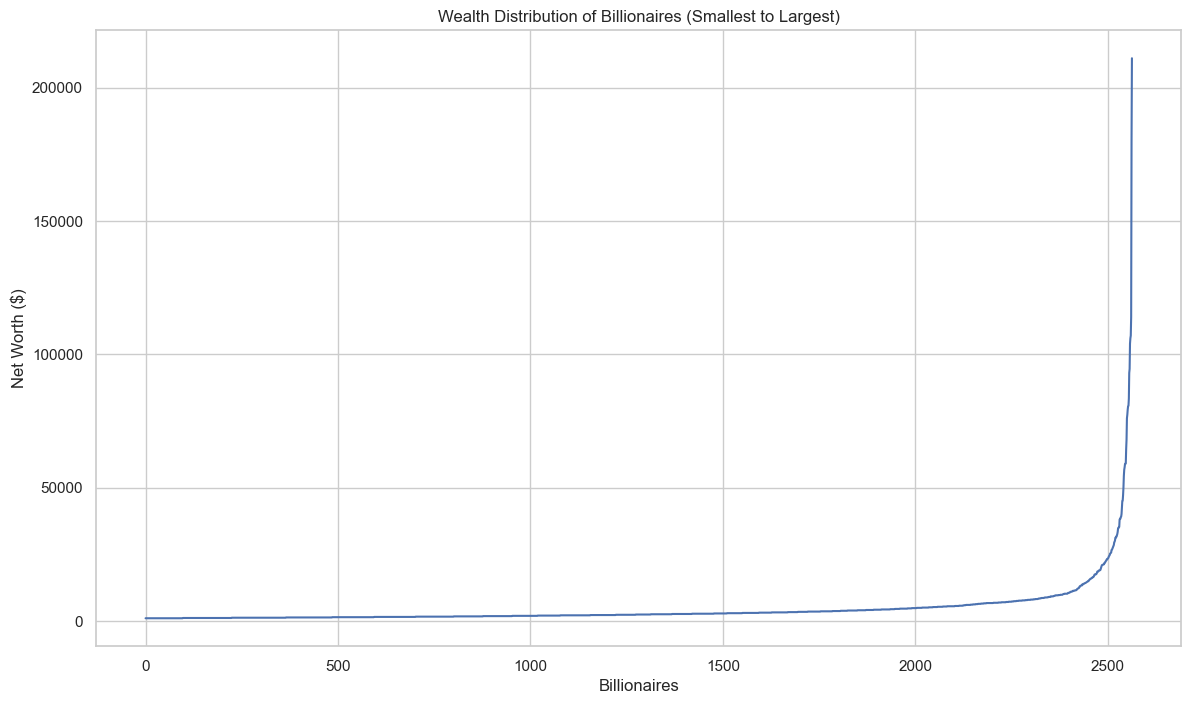

                               personName  finalWorth
10  Francoise Bettencourt Meyers & family       80500
9                           Steve Ballmer       80700
8                           Mukesh Ambani       83400
7               Carlos Slim Helu & family       93000
6                       Michael Bloomberg       94500
5                              Bill Gates      104000
4                          Warren Buffett      106000
3                           Larry Ellison      107000
2                              Jeff Bezos      114000
1                               Elon Musk      180000
0                Bernard Arnault & family      211000


In [41]:
# Wealth Distribution (Smallest to Largest)

# Sort data by 'finalWorth' and plot it
sorted_data = data.sort_values(by='finalWorth', ascending=True)
plt.figure(figsize=(14, 8))
plt.plot(sorted_data['finalWorth'].values)
plt.title('Wealth Distribution of Billionaires (Smallest to Largest)')
plt.xlabel('Billionaires')
plt.ylabel('Net Worth ($)')
plt.show()

# Get top 10% of billionaires by total wealth
total_finalWorth = data['finalWorth'].sum()
top_10_percent_threshold = total_finalWorth * 0.9
sorted_data['cumulative_wealth'] = sorted_data['finalWorth'].cumsum()
top_10_percent = sorted_data[sorted_data['cumulative_wealth'] >= top_10_percent_threshold]
print(top_10_percent[['personName', 'finalWorth']])

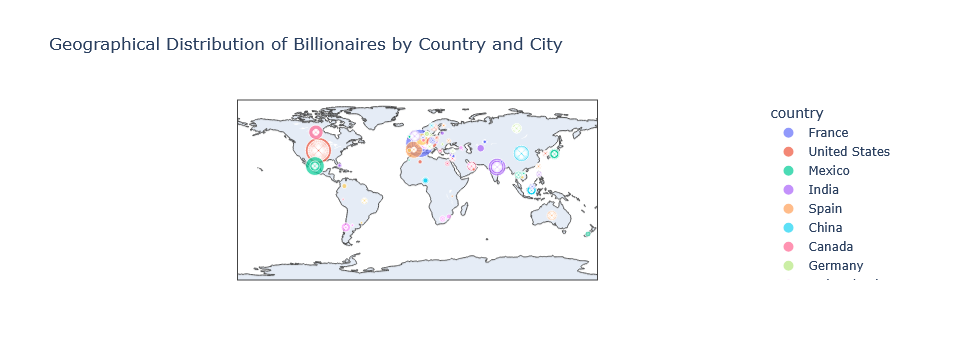

In [17]:
# Geographical Distribution of Billionaires (Map of Countries and Cities)

# Visualize distribution of billionaire wealth by country and city
fig_geo = px.scatter_geo(data, locations="country", locationmode="country names", 
                         color="country", size="finalWorth",
                         hover_name="personName", 
                         hover_data={"finalWorth": True, "city": True},
                         title="Geographical Distribution of Billionaires by Country and City")
fig_geo.show()

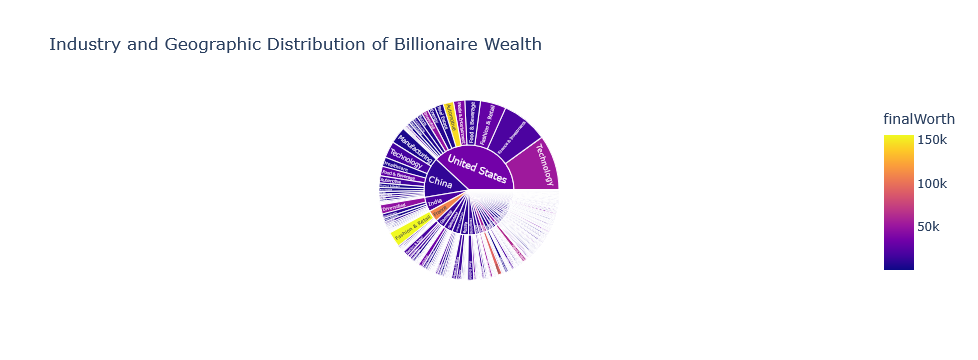

In [18]:
# Wealth Distribution by Industry and Geography (Sunburst Chart)
# Visualize industry-based wealth distribution across countries
fig_industry_geo = px.sunburst(data, path=['country', 'industries'], values='finalWorth',
                               color='finalWorth', 
                               hover_data={'personName': True},
                               title="Industry and Geographic Distribution of Billionaire Wealth")
fig_industry_geo.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\2379124636.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




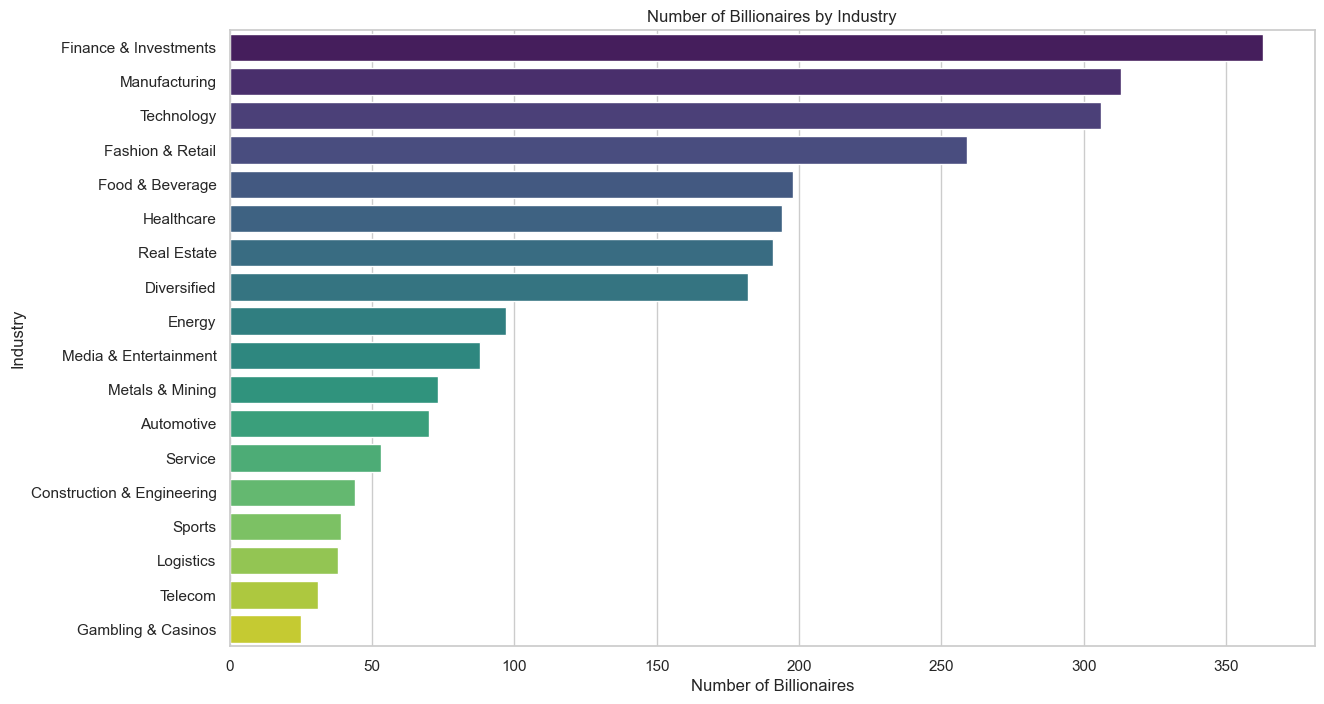

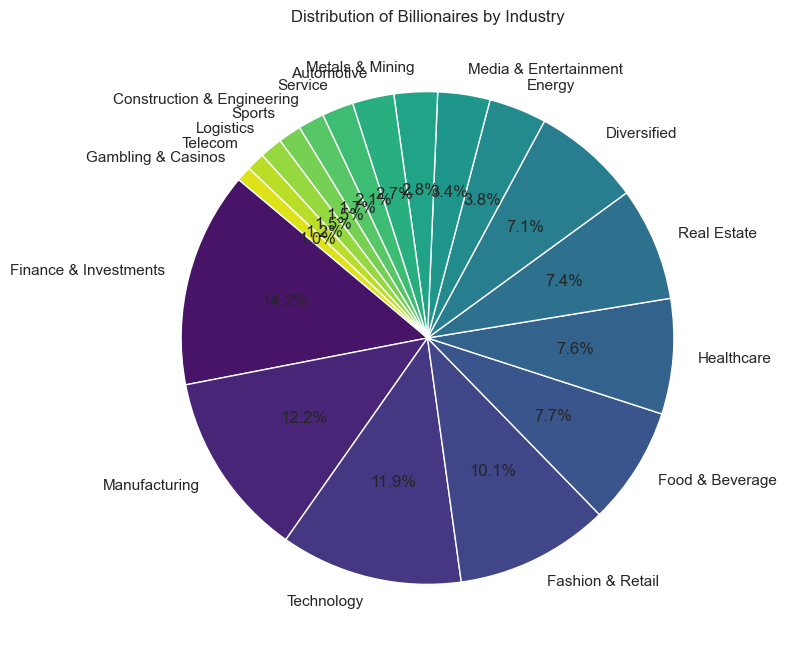

In [19]:
# Count the number of billionaires by industry
industry_counts = data['industries'].value_counts().reset_index()
industry_counts.columns = ['Industry', 'Count']

# 1. Bar plot to show the number of billionaires by industry
plt.figure(figsize=(14, 8))
sns.barplot(data=industry_counts, x='Count', y='Industry', palette='viridis')
plt.title('Number of Billionaires by Industry')
plt.xlabel('Number of Billionaires')
plt.ylabel('Industry')
plt.show()

# 2. Pie chart to visualize the distribution of billionaires across industries
plt.figure(figsize=(10, 8))
plt.pie(industry_counts['Count'], labels=industry_counts['Industry'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(industry_counts)))
plt.title('Distribution of Billionaires by Industry')
plt.show()


C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1173118696.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




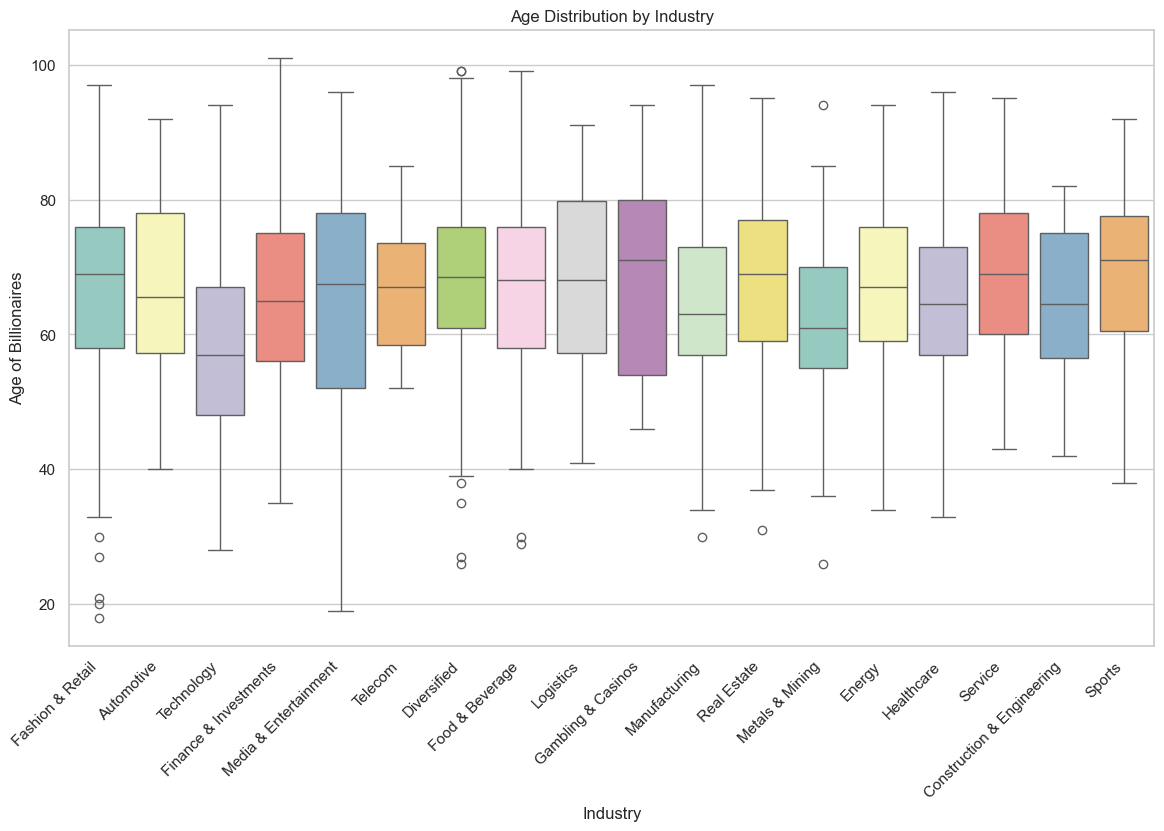

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1173118696.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




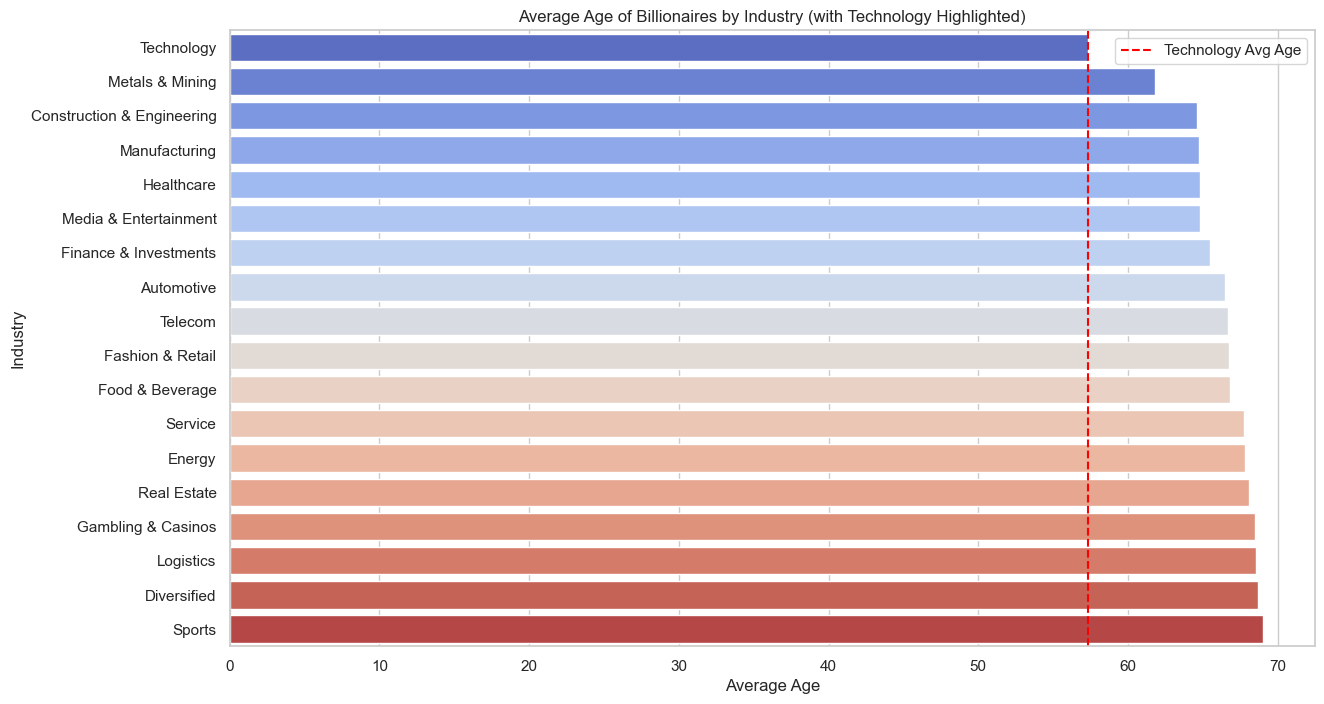

In [20]:
# Filter the dataset to include only age and industry columns and drop any missing values
industry_age_data = data[['age', 'industries']].dropna()

# 1. Boxplot to show the age distribution across industries, highlighting younger trends in specific sectors
plt.figure(figsize=(14, 8))
sns.boxplot(data=industry_age_data, x='industries', y='age', palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.title('Age Distribution by Industry')
plt.xlabel('Industry')
plt.ylabel('Age of Billionaires')
plt.show()

# 2. Average age by industry with a focus on the technology sector
average_age_by_industry = industry_age_data.groupby('industries')['age'].mean().reset_index()
average_age_by_industry = average_age_by_industry.sort_values(by='age')

# Plot average age across industries and highlight the tech sector
plt.figure(figsize=(14, 8))
sns.barplot(data=average_age_by_industry, x='age', y='industries', palette='coolwarm')
plt.axvline(average_age_by_industry[average_age_by_industry['industries'] == 'Technology']['age'].values[0], color='red', linestyle='--', label="Technology Avg Age")
plt.title("Average Age of Billionaires by Industry (with Technology Highlighted)")
plt.xlabel("Average Age")
plt.ylabel("Industry")
plt.legend()
plt.show()


C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3094250155.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




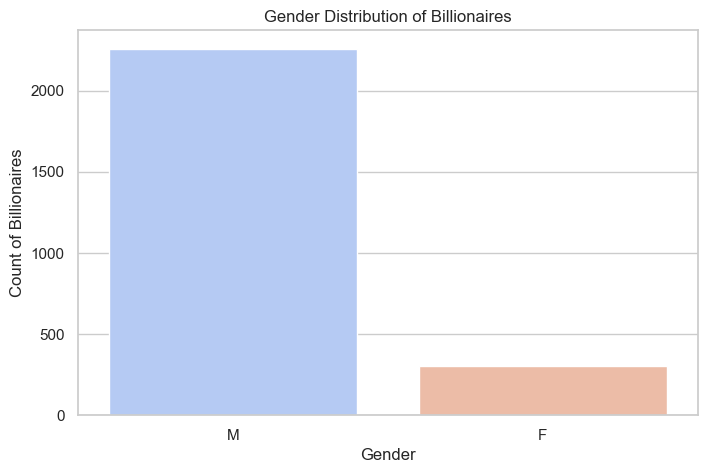

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3094250155.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




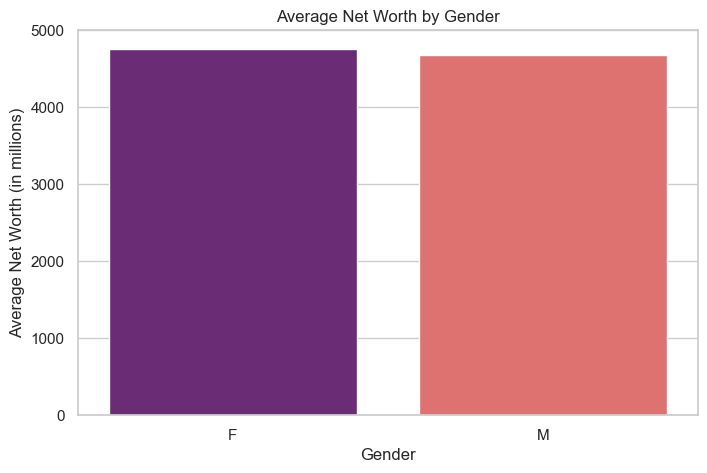

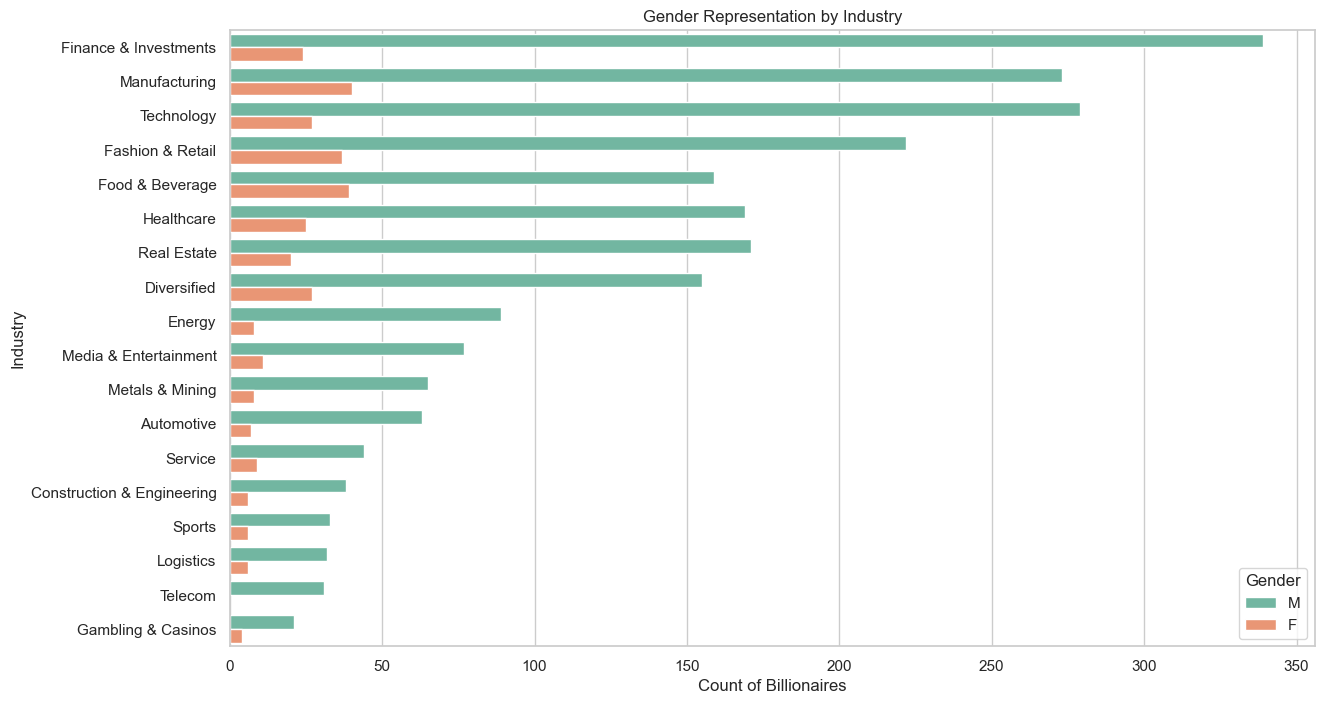

In [37]:
# Gender Distribution: Count of Male vs. Female Billionaires
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='gender', palette='coolwarm')
plt.title("Gender Distribution of Billionaires")
plt.xlabel("Gender")
plt.ylabel("Count of Billionaires")
plt.show()

# Average Net Worth by Gender
average_net_worth_by_gender = data.groupby('gender')['finalWorth'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=average_net_worth_by_gender, x='gender', y='finalWorth', palette='magma')
plt.title("Average Net Worth by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Net Worth (in millions)")
plt.show()

# Gender Representation by Industry (Comparative)
plt.figure(figsize=(14, 8))
sns.countplot(data=data, y='industries', hue='gender', palette='Set2', order=data['industries'].value_counts().index)
plt.title("Gender Representation by Industry")
plt.xlabel("Count of Billionaires")
plt.ylabel("Industry")
plt.legend(title="Gender")
plt.show()

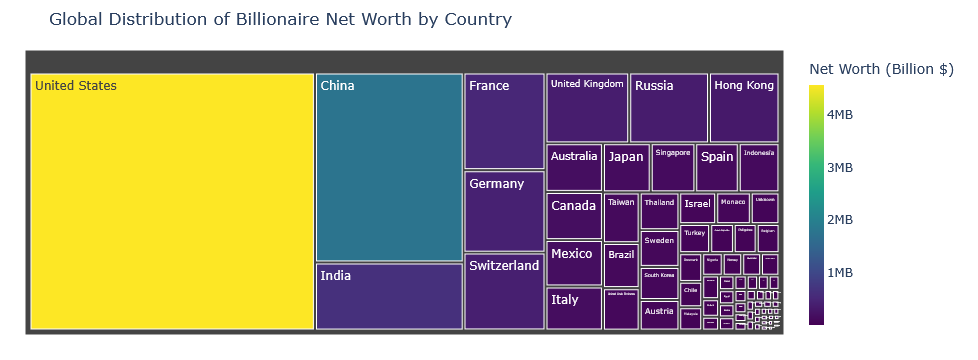

In [38]:
# Group by country and calculate the total net worth for each country
country_wealth = data.groupby('country', as_index=False)['finalWorth'].sum()  # Use 'finalWorth' or the correct column name

# Create a treemap
fig = px.treemap(
    country_wealth, 
    path=['country'],  # Hierarchical path
    values='finalWorth',  # Use 'finalWorth' or correct column name
    color='finalWorth',  # Use 'finalWorth' or correct column name
    color_continuous_scale='viridis',  # Color scale
    title='Global Distribution of Billionaire Net Worth by Country'
)

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),  # Set margins
    coloraxis_colorbar=dict(
        title="Net Worth (Billion $)", 
        ticksuffix="B", 
        thickness=15
    )
)

# Show the treemap
fig.show()

In [23]:
# **Calculate Total Number of Entries**
total_entries = data.shape[0]

# **Calculate Total Wealth**
# 'finalWorth' represents the wealth in millions
total_wealth = data['finalWorth'].sum()  # Total wealth in millions

# Convert total wealth to billions for readability
total_wealth_in_billions = total_wealth / 1e3

# **Display Results**
print(f"Total Number of Entries in the Dataset: {total_entries}")
print(f"Total Wealth Represented in the Dataset: ${total_wealth_in_billions:.2f} Billion")

Total Number of Entries in the Dataset: 2564
Total Wealth Represented in the Dataset: $12022.70 Billion


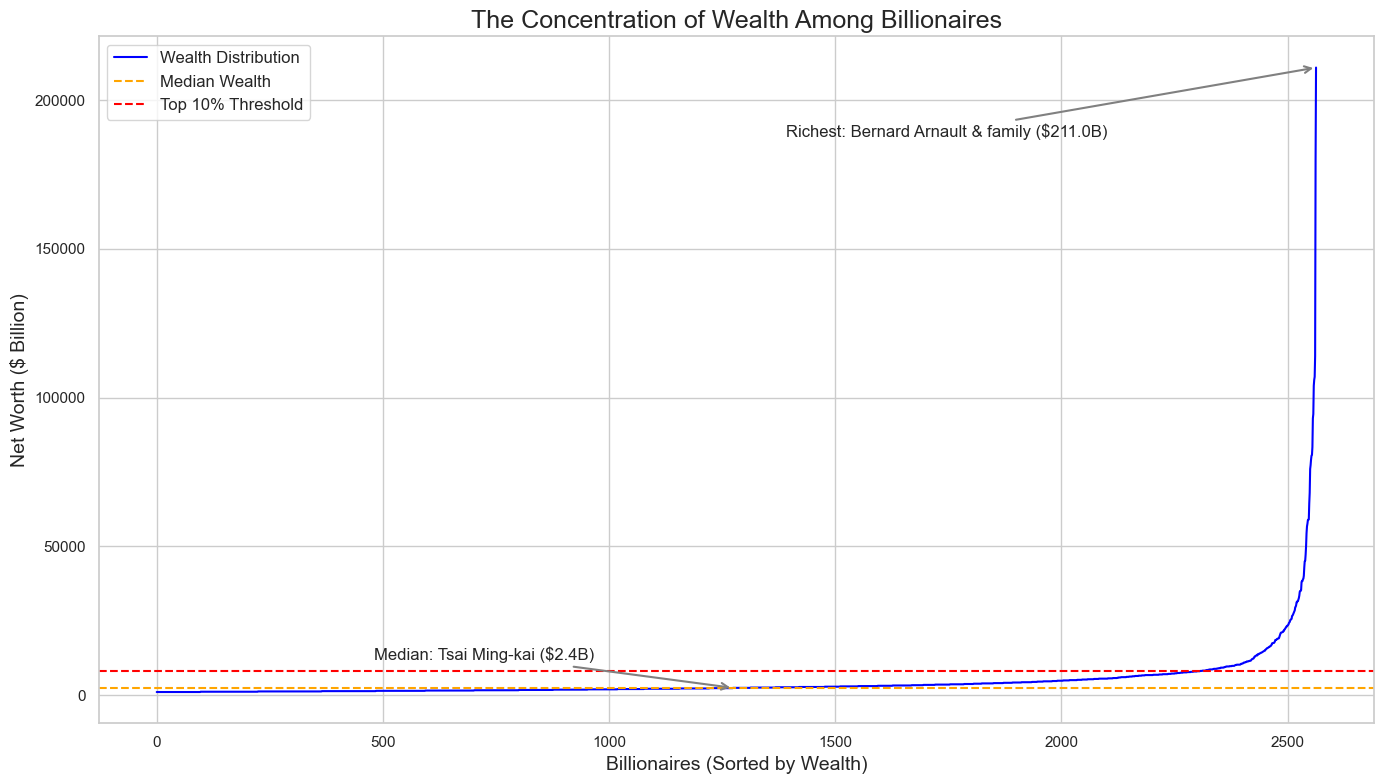

In [24]:
# **1. Sort the data by wealth**
sorted_data = data.sort_values(by='finalWorth', ascending=True)

# **2. Calculate thresholds for the top 10% and median**
top_10_percent_threshold = sorted_data['finalWorth'].quantile(0.9)
median_wealth = sorted_data['finalWorth'].median()

# **3. Highlight the richest and median entries**
richest_billionaire = sorted_data.iloc[-1]
median_billionaire = sorted_data[sorted_data['finalWorth'] == median_wealth].iloc[0]

# **4. Create the line plot for wealth distribution**
plt.figure(figsize=(14, 8))
plt.plot(sorted_data['finalWorth'].values, label='Wealth Distribution', color='blue')
plt.axhline(y=median_wealth, color='orange', linestyle='--', label='Median Wealth')
plt.axhline(y=top_10_percent_threshold, color='red', linestyle='--', label='Top 10% Threshold')

# Annotate the richest billionaire (inside the graph)
plt.annotate(
    f"Richest: {richest_billionaire['personName']} (${richest_billionaire['finalWorth'] / 1e3:.1f}B)", 
    xy=(len(sorted_data) - 1, richest_billionaire['finalWorth']),
    xytext=(-150, -50),  # Shifted inside the graph
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='gray', lw=1.5),
    fontsize=12,  # Larger font size
    ha='right'
)

# Annotate the median billionaire (inside the graph)
plt.annotate(
    f"Median: {median_billionaire['personName']} (${median_billionaire['finalWorth'] / 1e3:.1f}B)", 
    xy=(sorted_data.index.get_loc(median_billionaire.name), median_wealth),
    xytext=(-100, 20),  # Shifted inside the graph
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='gray', lw=1.5),
    fontsize=12,  # Larger font size
    ha='right'
)

# **5. Add titles, labels, and legend**
plt.title('The Concentration of Wealth Among Billionaires', fontsize=18)
plt.xlabel('Billionaires (Sorted by Wealth)', fontsize=14)
plt.ylabel('Net Worth ($ Billion)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# **6. Show the plot**
plt.tight_layout()
plt.show()


Average Wealth of All Billionaires: $4.69 Billion
Average Wealth of Top 10% Billionaires: $22.31 Billion
The wealth of the Top 10% is 4.8 times greater than the average.


C:\Users\milto\AppData\Local\Temp\ipykernel_5676\924713859.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




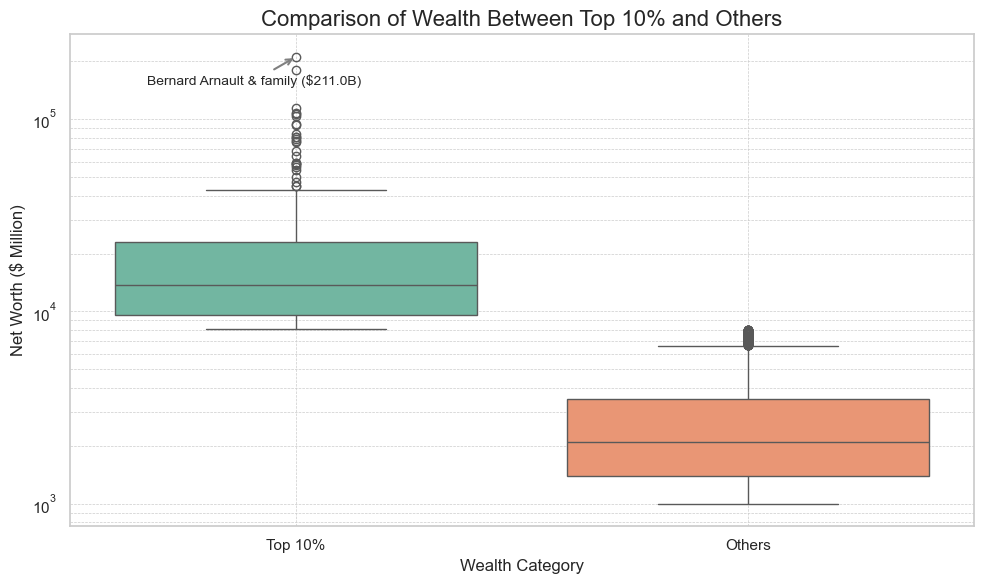

In [25]:
# **1. Define the Top 10% Wealth Threshold**
top_10_percent_threshold = data['finalWorth'].quantile(0.9)

# **2. Categorize Billionaires**
data['Wealth Category'] = ['Top 10%' if x >= top_10_percent_threshold else 'Others' for x in data['finalWorth']]

# **3. Calculate Summary Statistics**
average_wealth = data['finalWorth'].mean()
top_10_average_wealth = data[data['Wealth Category'] == 'Top 10%']['finalWorth'].mean()

# Display standout statistics
print(f"Average Wealth of All Billionaires: ${average_wealth / 1e3:.2f} Billion")
print(f"Average Wealth of Top 10% Billionaires: ${top_10_average_wealth / 1e3:.2f} Billion")
print(f"The wealth of the Top 10% is {top_10_average_wealth / average_wealth:.1f} times greater than the average.")

# **4. Visualization: Box Plot**
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Wealth Category', y='finalWorth', palette='Set2')
plt.title('Comparison of Wealth Between Top 10% and Others', fontsize=16)
plt.xlabel('Wealth Category', fontsize=12)
plt.ylabel('Net Worth ($ Million)', fontsize=12)
plt.yscale('log')  # Use logarithmic scale for better visualization of disparities
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Highlight standout billionaires
richest_billionaire = data[data['finalWorth'] == data['finalWorth'].max()]
plt.annotate(
    f"{richest_billionaire.iloc[0]['personName']} (${richest_billionaire.iloc[0]['finalWorth'] / 1e3:.1f}B)", 
    xy=(0, richest_billionaire['finalWorth'].max()), 
    xytext=(-30, -20), 
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='gray', lw=1.5),
    fontsize=10,
    ha='center'
)

# Show the plot
plt.tight_layout()
plt.show()

Average Age of Billionaires: 65.2 years
Youngest Billionaire: Clemente Del Vecchio, Age 18.0
Oldest Billionaire: George Joseph, Age 101.0


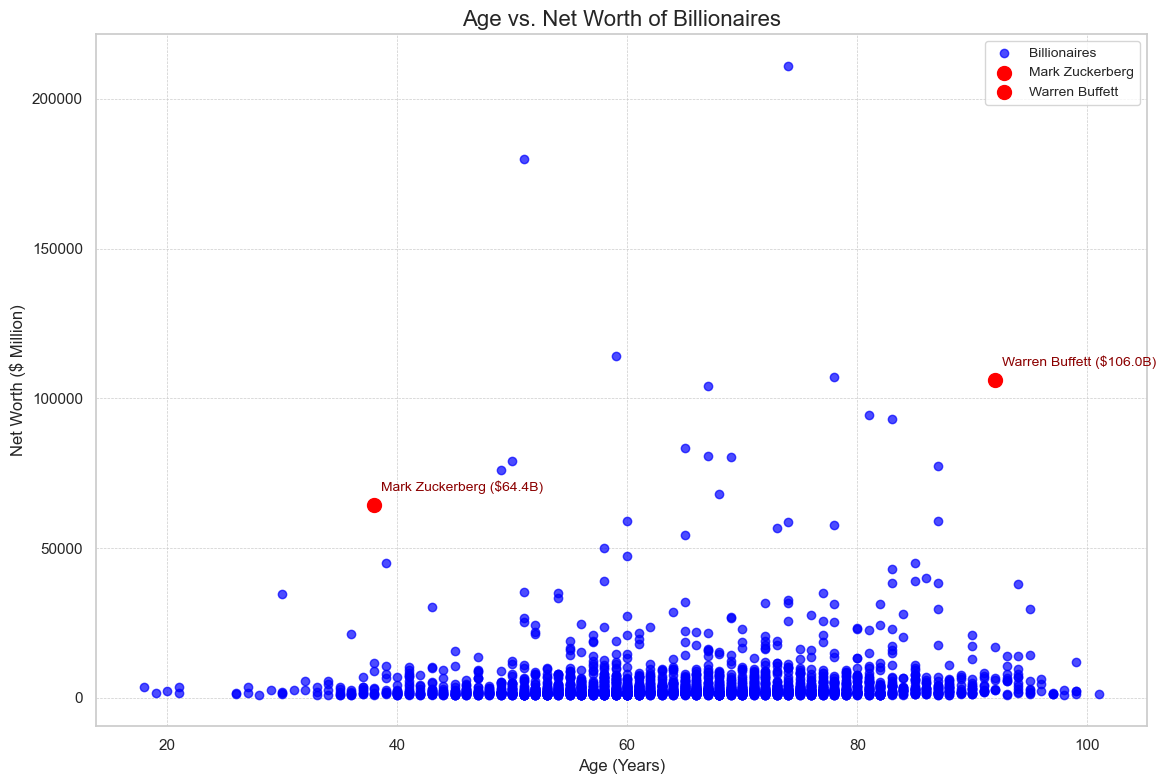

In [26]:
# **1. Calculate Age Statistics**
average_age = data['age'].mean()
youngest_billionaire = data[data['age'] == data['age'].min()]
oldest_billionaire = data[data['age'] == data['age'].max()]

# Display age trends
print(f"Average Age of Billionaires: {average_age:.1f} years")
print(f"Youngest Billionaire: {youngest_billionaire.iloc[0]['personName']}, Age {youngest_billionaire.iloc[0]['age']}")
print(f"Oldest Billionaire: {oldest_billionaire.iloc[0]['personName']}, Age {oldest_billionaire.iloc[0]['age']}")

# **2. Scatter Plot: Age vs. Net Worth**
plt.figure(figsize=(12, 8))
plt.scatter(data['age'], data['finalWorth'], alpha=0.7, color='blue', label='Billionaires')
plt.title('Age vs. Net Worth of Billionaires', fontsize=16)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Net Worth ($ Million)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Highlight specific outliers (e.g., Mark Zuckerberg and Warren Buffett)
# Replace 'Mark Zuckerberg' and 'Warren Buffett' with actual names in your dataset
highlight_names = ['Mark Zuckerberg', 'Warren Buffett']
for name in highlight_names:
    outlier = data[data['personName'] == name]
    if not outlier.empty:
        plt.scatter(outlier['age'], outlier['finalWorth'], color='red', s=100, label=f"{name}")
        plt.annotate(
            f"{name} (${outlier.iloc[0]['finalWorth'] / 1e3:.1f}B)", 
            xy=(outlier.iloc[0]['age'], outlier.iloc[0]['finalWorth']),
            xytext=(5, 10), 
            textcoords='offset points',
            fontsize=10,
            color='darkred'
        )

# Add legend
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Total Billionaires: 2564
Female Billionaires: 0 (0.0%)
Male Billionaires: 0


C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3862870242.py:19: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3862870242.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




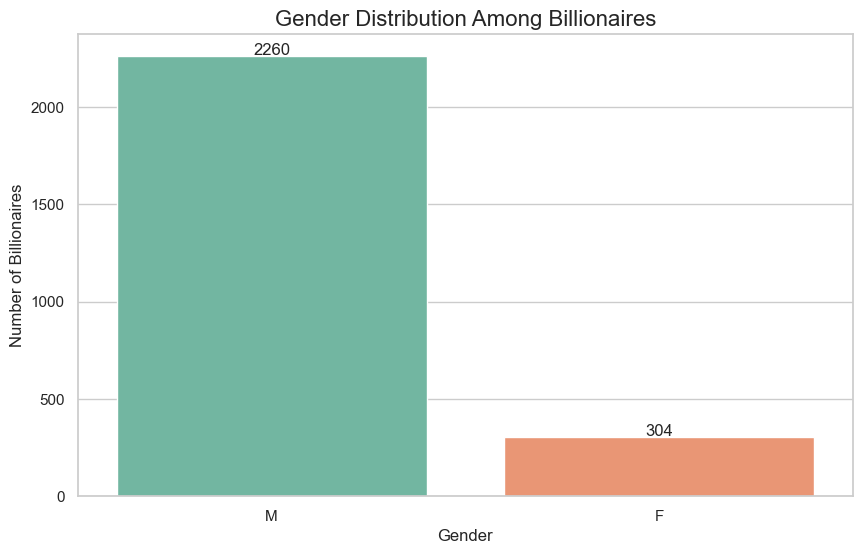

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\3862870242.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




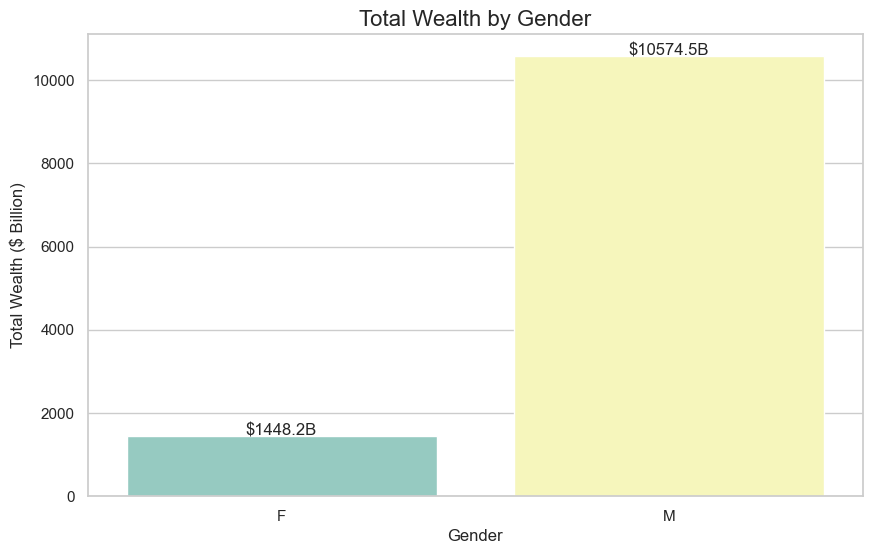

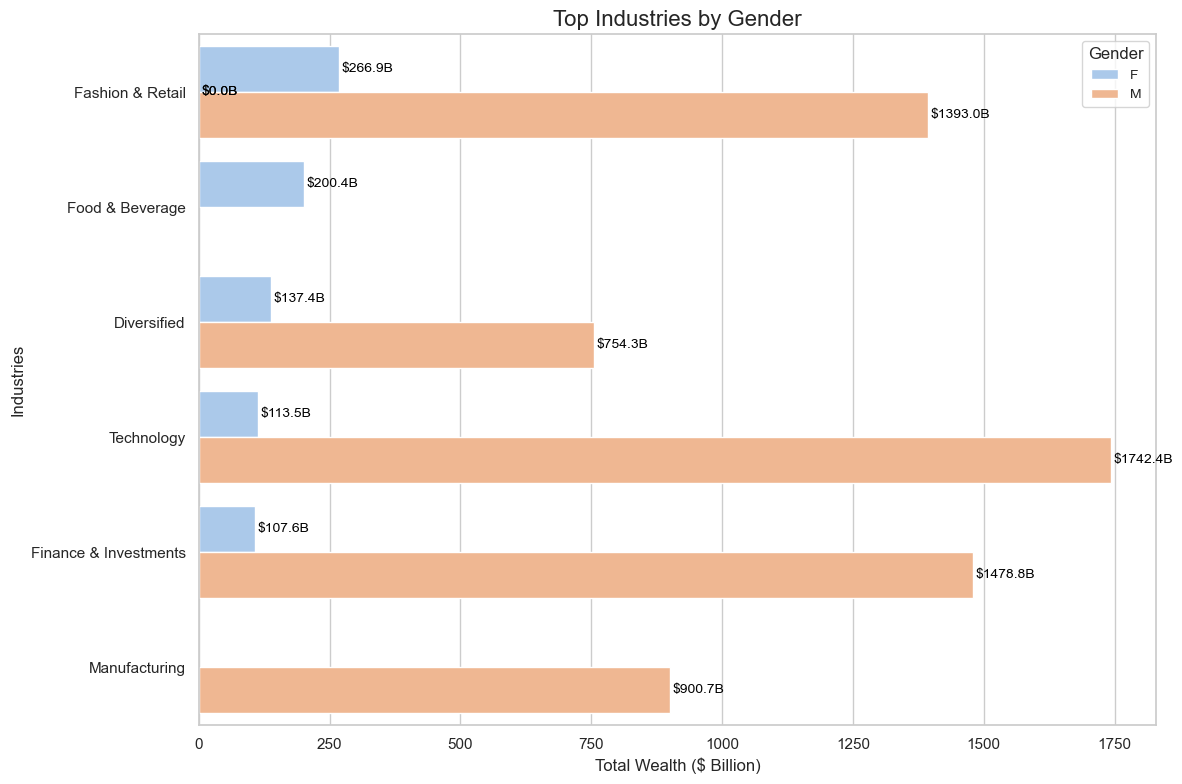

In [27]:
# **1. Analyze Gender Distribution**
gender_counts = data['gender'].value_counts()
female_percentage = (gender_counts.get('Female', 0) / gender_counts.sum()) * 100

# Display gender statistics
print(f"Total Billionaires: {gender_counts.sum()}")
print(f"Female Billionaires: {gender_counts.get('Female', 0)} ({female_percentage:.1f}%)")
print(f"Male Billionaires: {gender_counts.get('Male', 0)}")

# **2. Aggregate Wealth by Gender**
wealth_by_gender = data.groupby('gender')['finalWorth'].sum().reset_index()
wealth_by_gender['finalWorth_billion'] = wealth_by_gender['finalWorth'] / 1e3  # Convert to billions

# **3. Wealth by Gender and Industry**
wealth_gender_industry = data.groupby(['gender', 'industries'])['finalWorth'].sum().reset_index()
wealth_gender_industry['finalWorth_billion'] = wealth_gender_industry['finalWorth'] / 1e3  # Convert to billions

# Top 5 industries for each gender
top_industries_by_gender = wealth_gender_industry.groupby('gender').apply(
    lambda x: x.sort_values(by='finalWorth', ascending=False).head(5)
).reset_index(drop=True)

# **4. Bar Chart: Gender Distribution**
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='Set2')
plt.title('Gender Distribution Among Billionaires', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)

# Add annotations
for i, value in enumerate(gender_counts.values):
    ax.text(i, value + 5, f"{value}", ha='center', fontsize=12)

plt.show()

# **5. Bar Chart: Total Wealth by Gender**
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='gender', y='finalWorth_billion', data=wealth_by_gender, palette='Set3')
plt.title('Total Wealth by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Total Wealth ($ Billion)', fontsize=12)

# Add annotations
for i, value in enumerate(wealth_by_gender['finalWorth_billion']):
    ax.text(i, value + 20, f"${value:.1f}B", ha='center', fontsize=12)

plt.show()

# **6. Industry Comparison: Top Industries by Gender**
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='finalWorth_billion', 
    y='industries', 
    hue='gender', 
    data=top_industries_by_gender, 
    palette='pastel'
)
plt.title('Top Industries by Gender', fontsize=16)
plt.xlabel('Total Wealth ($ Billion)', fontsize=12)
plt.ylabel('Industries', fontsize=12)
plt.legend(title='Gender', fontsize=10)

# Add annotations
for bar in ax.patches:
    x = bar.get_width()  # Bar width represents the wealth
    y = bar.get_y() + bar.get_height() / 2  # Center of the bar
    ax.text(x + 5, y, f"${x:.1f}B", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [28]:
# List of top 10 individuals to analyze
top_individuals = [
    "Elon Musk", "Jeff Bezos", "Bernard Arnault & Family", "Mark Zuckerberg",
    "Larry Ellison", "Warren Buffett", "Bill Gates", "Larry Page",
    "Sergey Brin", "Steve Ballmer"
]

# **1. Filter dataset for top individuals**
top_individuals_data = data[data['personName'].isin(top_individuals)]

# **2. Calculate total net worth for the top individuals**
top_individuals_total_wealth = top_individuals_data['finalWorth'].sum()  # Assuming 'finalWorth' represents wealth in millions

# **3. Calculate total wealth in the dataset**
total_wealth = data['finalWorth'].sum()

# **4. Calculate percentage representation**
percentage_of_total = (top_individuals_total_wealth / total_wealth) * 100

# **5. Display Results**
print(f"Total Net Worth of Top 10 Individuals: ${top_individuals_total_wealth / 1e3:.2f} Billion")
print(f"Total Wealth in Dataset: ${total_wealth / 1e3:.2f} Billion")
print(f"Percentage of Total Wealth Represented by Top 10 Individuals: {percentage_of_total:.2f}%")

Total Net Worth of Top 10 Individuals: $911.30 Billion
Total Wealth in Dataset: $12022.70 Billion
Percentage of Total Wealth Represented by Top 10 Individuals: 7.58%


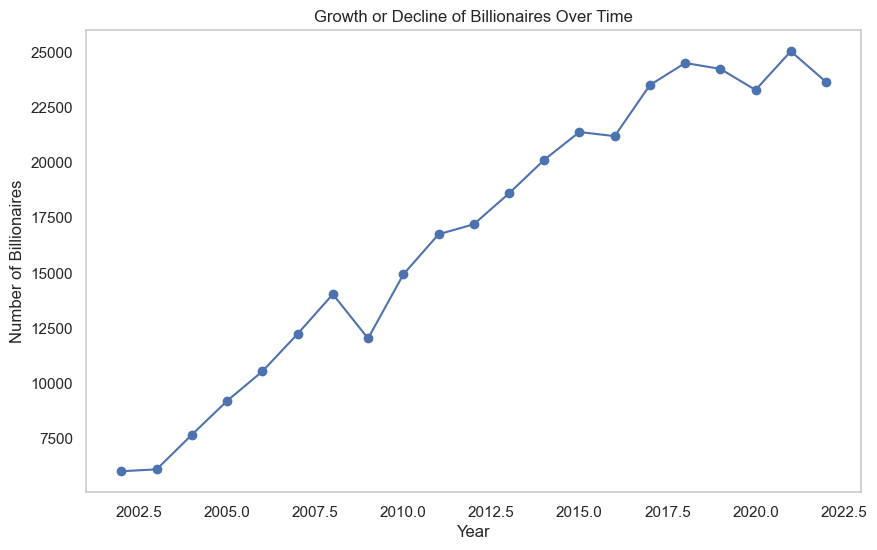

In [31]:
# Trend Analysis: Growth or Decline of Billionaires Over Time**
# Count number of billionaires by year
if 'time' in df_second.columns:
    billionaires_by_year = df_second.groupby('time').size()

    # Plot line chart
    plt.figure(figsize=(10, 6))
    billionaires_by_year.plot(kind='line', marker='o')
    plt.title('Growth or Decline of Billionaires Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Billionaires')
    plt.grid()
    plt.show()

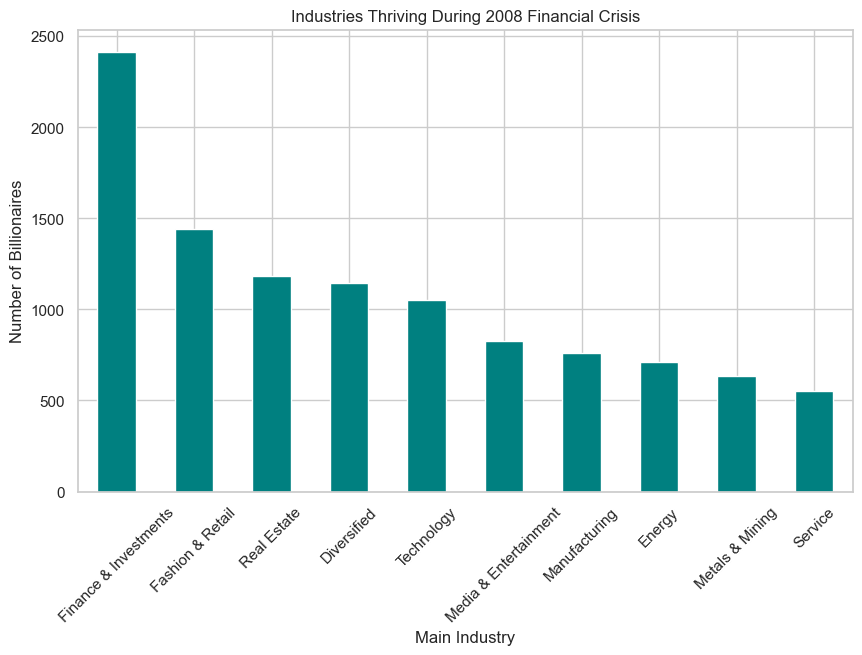

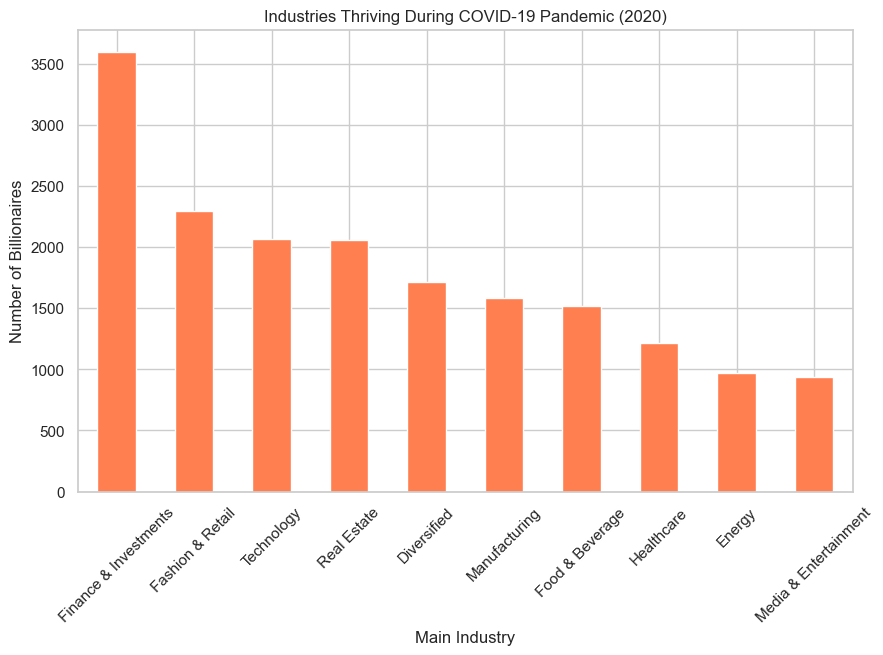

In [32]:
# Industries Thriving During Economic Turmoil**
# Filter data for specific years of turmoil
if 'time' in df_second.columns:
    # 2008 Financial Crisis
    financial_crisis = df_second[df_second['time'] == 2008]
    crisis_industry_counts = financial_crisis['main_industry'].value_counts().head(10)

    # Bar chart for 2008
    plt.figure(figsize=(10, 6))
    crisis_industry_counts.plot(kind='bar', color='teal')
    plt.title('Industries Thriving During 2008 Financial Crisis')
    plt.xlabel('Main Industry')
    plt.ylabel('Number of Billionaires')
    plt.xticks(rotation=45)
    plt.show()

    # 2020 COVID-19 Pandemic
    pandemic = df_second[df_second['time'] == 2020]
    pandemic_industry_counts = pandemic['main_industry'].value_counts().head(10)

    # Bar chart for 2020
    plt.figure(figsize=(10, 6))
    pandemic_industry_counts.plot(kind='bar', color='coral')
    plt.title('Industries Thriving During COVID-19 Pandemic (2020)')
    plt.xlabel('Main Industry')
    plt.ylabel('Number of Billionaires')
    plt.xticks(rotation=45)
    plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\1350729429.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




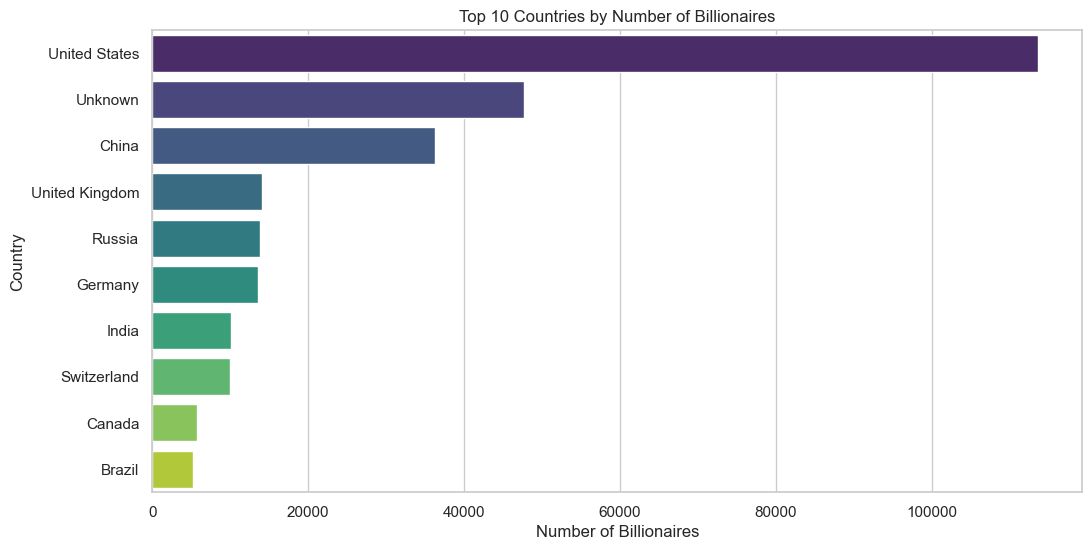

In [33]:
# Geographical Analysis: Global Billionaire Trends**
if 'country' in df_second.columns:
    # Number of billionaires by country
    billionaires_by_country = df_second['country'].value_counts().head(10)

    # Bar chart: Top 10 countries
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=billionaires_by_country.values,
        y=billionaires_by_country.index,
        palette='viridis'
    )
    plt.title('Top 10 Countries by Number of Billionaires')
    plt.xlabel('Number of Billionaires')
    plt.ylabel('Country')
    plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_5676\242014286.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




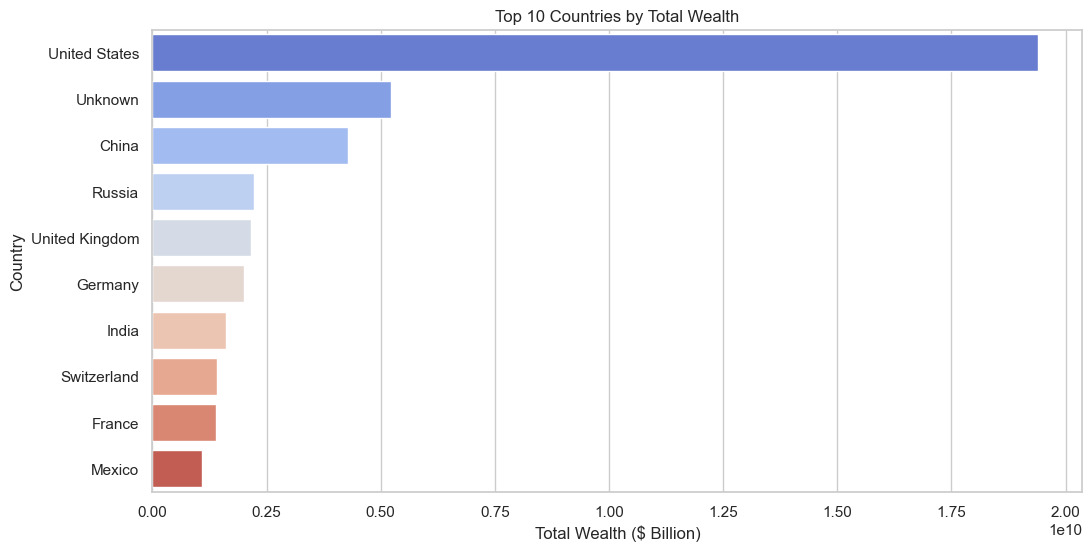

In [34]:
# Wealth Distribution Across Countries**
if 'annual_income' in df_second.columns and 'country' in df_second.columns:
    wealth_by_country = df_second.groupby('country')['annual_income'].sum().sort_values(ascending=False).head(10)

    # Bar chart: Wealth distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=wealth_by_country.values / 1e3,  # Convert to billion
        y=wealth_by_country.index,
        palette='coolwarm'
    )
    plt.title('Top 10 Countries by Total Wealth')
    plt.xlabel('Total Wealth ($ Billion)')
    plt.ylabel('Country')
    plt.show()
